In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from ridge import RidgeRegression# import pandas module
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Fetching the California housing dataset
california = fetch_california_housing()
X, y = california.data, california.target

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# Your custom Ridge Regression
custom_model = RidgeRegression(alpha=1.0,solver="cholesky")
custom_model.fit(X_train, y_train)
custom_predictions = custom_model.predict(X_test)
custom_mse = mean_squared_error(y_test, custom_predictions)

# Scikit-learn's Ridge Regression
sklearn_model = Ridge(alpha=1.0)
sklearn_model.fit(X_train, y_train)
sklearn_predictions = sklearn_model.predict(X_test)
sklearn_mse = mean_squared_error(y_test, sklearn_predictions)

print("Custom Model MSE:", custom_mse)
print("Scikit-learn Model MSE:", sklearn_mse)


Custom Model MSE: 0.5558034669931597
Scikit-learn Model MSE: 0.5558034669932194


Now Lets test on the olympic dataset

In [5]:
df = pd.read_csv("Olympic.csv")

# Assuming we want to use the last 5 data points as test set
train_df = df[:-3]
test_df = df[-3:]

# Extract features and target
X_train = train_df[['Year']].values
y_train = train_df['Time'].values
X_test = test_df[['Year']].values
y_test = test_df['Time'].values


# Initialize and fit the custom Ridge Regression model
model = RidgeRegression(alpha=1.0, solver='cholesky')
model.fit(X_train, y_train)

# Predictions and evaluation
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mse

0.05226843207053709

Predicted time for the next year: 9.60 seconds
[9.6047097  9.55253537 9.50036104]


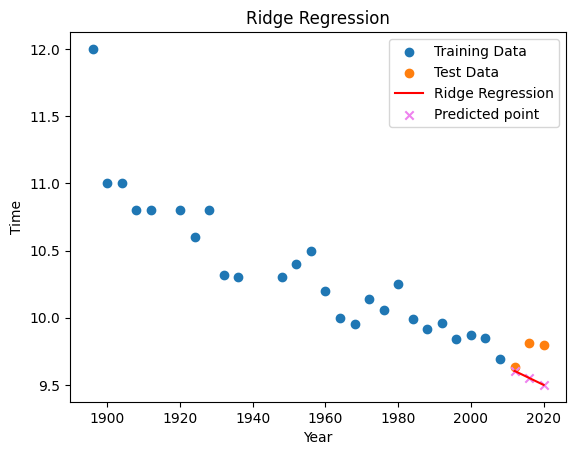

In [10]:
# Initialize and fit the custom Ridge Regression model
model = Ridge(alpha=4, solver='svd')
model.fit(X_train, y_train)

# Predictions and evaluation
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mse

print(f'Predicted time for the next year: {predictions[0]:.2f} seconds')
print(predictions)

# Plot the regression line
plt.scatter(X_train, y_train, label='Training Data')
plt.scatter(X_test, y_test, label='Test Data')
plt.plot(X_test, model.predict(X_test), color='red', label='Ridge Regression')
plt.scatter(X_test, predictions, color='violet', marker='x', label='Predicted point')



plt.xlabel('Year')
plt.ylabel('Time')
plt.title('Ridge Regression')
plt.legend()
plt.show()